# Homework 4

We have learned about the basics of using machine learning and deep learning for many computer vision problems. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

First of all, you may want to do `conda install pytorch torchvision -c pytorch` in your virtual environment to install PyTorch.

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`. 

As a quick refresher question. Why do we want to split our data into training and testing sets? (5 points)


**You answer here:** Write your answer in this markdown cell.

- 评估泛化能力：测试集模拟了模型在真实世界中会遇到的新数据，用它来评估模型对这些新数据的预测准确性。
- 防止过拟合：如果模型在训练集上表现很好，但在测试集上表现差，就说明模型可能过拟合了（当然，这一般是验证集做的事，测试集也可以）。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
# set random seeds
torch.manual_seed(2023)
np.random.seed(2023)
random.seed(2023)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10, so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

Why do we want to normalize the images beforehand? (5 points)


*HINT*: consider the fact that the network we developed will be deployed to a large number of images. 

**You answer here:** Write your answer in this markdown cell.

- 确保输入数据的一致性：部署时，模型会遇到来自不同来源、不同光照条件、不同拍摄设备的图像。归一化可以将这些具有不同原始尺度和分布的图像转换到一个统一的标准范围内。这使得模型在处理新图像- 时，输入的特征具有相似的尺度和分布，从而保证模型在新图像上表现的稳定性和可靠性。
- 加速模型训练和收敛：在一定程度上归一化可以使损失函数的梯度更均匀，帮助优化算法更快地找到最优解，避免因某些特征值过大导致训练不稳定。
- 提高模型的泛化能力和鲁棒性：通过将所有图像都进行相同的归一化处理，模型学习到的特征对光照、对比度等外部因素的变化不那么敏感。这使得模型对未见过但经过同样归一化处理的图像有更好的适应性。
- 避免数值问题：较大的像素值（如0-255）在网络计算中可能导致数值溢出或梯度爆炸/消失等问题，尤其是在深层网络中。归一化到较小范围可以提高计算的稳定性。

In [2]:
trainloader = None
testloader = None
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data",  
    train=True,  
    download=True,  
    transform=transform,
)  

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=2,
)  

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,  
    download=True,
    transform=transform,
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,  
    num_workers=2,
)

# these are the 10 classes we have in CIFAR10
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
# running this block will take a few minutes to download the dataset if you haven't done so

Let's plot out some training images to see what we are dealing with:

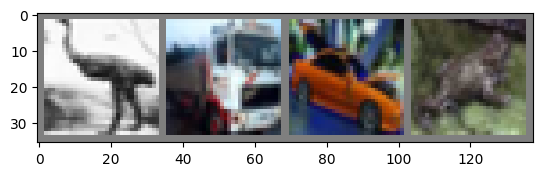

 bird truck   car  frog


In [3]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `network.py`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output. (15 points)

In [4]:
from network import Net
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start). 

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take just several minutes on your device(CPU or GPU).

In [6]:
epoch_num = 2
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        ### YOUR CODE HERE (10 points)
        # zero the parameter gradients
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ### END YOUR CODE

        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.186
[1,  4000] loss: 1.848
[1,  6000] loss: 1.689
[1,  8000] loss: 1.587
[1, 10000] loss: 1.515
[1, 12000] loss: 1.467
[2,  2000] loss: 1.417
[2,  4000] loss: 1.403
[2,  6000] loss: 1.353
[2,  8000] loss: 1.335
[2, 10000] loss: 1.295
[2, 12000] loss: 1.289
Finished Training


The last step of training is to save the trained model locally to a checkpoint:

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

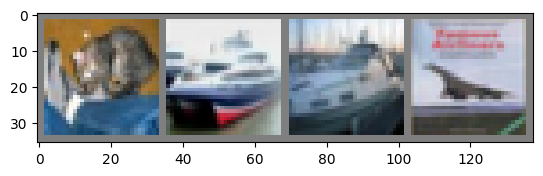

GroundTruth:    cat  ship  ship plane


In [8]:
testiter = iter(testloader)
images, labels = next(testiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let's load in our saved model checkpoint and get its output:

In [9]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []
### YOUR CODE HERE ###

net.eval()

with torch.no_grad():
    outputs = net(images) 
    _, predicted_indices = torch.max(outputs, 1)
    predicted = predicted_indices.cpu().tolist()
### END YOUR CODE ###
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


How does your prediction look like? Does that match your expectation? Write a few sentences to describe what you got and provide some analysis if you have any. (5 points)

**You answer here:** Write your answer in this markdown cell.

我的结果：Predicted:    cat  ship  ship plane，只训练了两轮，比较意外四个都是对的

Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [11]:
correct = 0
total = 0
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images) 
        _, predicted_indices = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted_indices == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better? (5 points)

**You answer here:** Write your answer in this markdown cell.
我的正确率为55%


Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
with torch.no_grad(): 
    for data in testloader: 
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(labels.size(0)): 
            label = labels[i].item()    
            predict = predicted[i].item() 

            class_total[label] += 1

            if label == predict:
                class_correct[label] += 1

for i in range(10):
    if class_total[i] > 0: 
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (
            classes[i], accuracy))
    else:
        print('Accuracy of %5s : N/A (no samples in test set)' % (
            classes[i]))

Accuracy of plane : 66 %
Accuracy of   car : 61 %
Accuracy of  bird : 42 %
Accuracy of   cat : 41 %
Accuracy of  deer : 41 %
Accuracy of   dog : 48 %
Accuracy of  frog : 64 %
Accuracy of horse : 65 %
Accuracy of  ship : 61 %
Accuracy of truck : 66 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance as much as possible. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not? (15 points)

In [3]:
# ======================================================================
# 0. 超参数和配置
# ======================================================================
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
BATCH_SIZE = 4

# 损失函数类型
# 可选: "CrossEntropyLoss", "KLDivLoss", "NLLLoss"
LOSS_FUNCTION_TYPE = "KLDivLoss" 

# 优化器类型
# 可选: "SGD", "Adam", "AdamW", "RMSprop"
OPTIMIZER_TYPE = "SGD"  

# SGD优化器特定参数
SGD_MOMENTUM = 0.9

# Adam / AdamW 优化器的特定参数
ADAM_BETAS = (0.9, 0.999)
ADAM_EPS = 1e-8
ADAM_WEIGHT_DECAY = 0.01 # AdamW 使用这个进行权重衰减

# RMSprop 优化器的特定参数
RMSPROP_ALPHA = 0.99 # 平滑常数
RMSPROP_EPS = 1e-8
RMSPROP_MOMENTUM = 0 # RMSprop也可以有动量
RMSPROP_CENTERED = False # 是否计算中心化的RMSprop

# ======================================================================
# 1. 导入库、定义网络、设备、损失函数和优化器
# ======================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from network import ModifiedNet 

# 数据转换
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 加载CIFAR-10训练集
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

# 加载CIFAR-10测试集
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

# CIFAR-10的10个类别
classes = (
    "plane", "car", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck",
)
NUM_CLASSES = len(classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用的设备是: {device}")

net = ModifiedNet()
net.to(device)

# 根据超参数选择损失函数
log_softmax_layer = None # KLDivLoss 和 NLLLoss 需要它
if LOSS_FUNCTION_TYPE == "CrossEntropyLoss":
    criterion = nn.CrossEntropyLoss()
    print(f"使用损失函数: {LOSS_FUNCTION_TYPE}")
elif LOSS_FUNCTION_TYPE == "KLDivLoss":
    criterion = nn.KLDivLoss(reduction='batchmean')
    log_softmax_layer = nn.LogSoftmax(dim=1)
    print(f"使用损失函数: {LOSS_FUNCTION_TYPE}")
elif LOSS_FUNCTION_TYPE == "NLLLoss":
    criterion = nn.NLLLoss()
    log_softmax_layer = nn.LogSoftmax(dim=1) # NLLLoss 通常与 LogSoftmax 结合使用
    print(f"使用损失函数: {LOSS_FUNCTION_TYPE}")
else:
    raise ValueError(f"不支持的损失函数类型: {LOSS_FUNCTION_TYPE}")

# 根据超参数选择优化器
if OPTIMIZER_TYPE == "SGD":
    optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
    print(f"使用优化器: SGD (lr={LEARNING_RATE}, momentum={SGD_MOMENTUM})")
elif OPTIMIZER_TYPE == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS, eps=ADAM_EPS)
    print(f"使用优化器: Adam (lr={LEARNING_RATE}, betas={ADAM_BETAS}, eps={ADAM_EPS})")
elif OPTIMIZER_TYPE == "AdamW":
    optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS, eps=ADAM_EPS, weight_decay=ADAM_WEIGHT_DECAY)
    print(f"使用优化器: AdamW (lr={LEARNING_RATE}, betas={ADAM_BETAS}, eps={ADAM_EPS}, weight_decay={ADAM_WEIGHT_DECAY})")
elif OPTIMIZER_TYPE == "RMSprop":
    optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE, alpha=RMSPROP_ALPHA, eps=RMSPROP_EPS, momentum=RMSPROP_MOMENTUM, centered=RMSPROP_CENTERED)
    print(f"使用优化器: RMSprop (lr={LEARNING_RATE}, alpha={RMSPROP_ALPHA}, momentum={RMSPROP_MOMENTUM}, centered={RMSPROP_CENTERED})")
else:
    raise ValueError(f"不支持的优化器类型: {OPTIMIZER_TYPE}")


# ======================================================================
# 2. 模型训练过程
# ======================================================================

print("开始训练...")
for epoch in range(NUM_EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs) # 网络的原始输出 (logits)

        if LOSS_FUNCTION_TYPE == "CrossEntropyLoss":
            loss = criterion(outputs, labels)
        elif LOSS_FUNCTION_TYPE == "KLDivLoss":
            log_probs = log_softmax_layer(outputs)
            # 将标签转换为 one-hot 编码的概率分布
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).float().to(device)
            loss = criterion(log_probs, labels_one_hot)
        elif LOSS_FUNCTION_TYPE == "NLLLoss":
            log_probs = log_softmax_layer(outputs) # 获取 log-probabilities
            loss = criterion(log_probs, labels)    

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Average Loss: {epoch_loss:.3f}")
print("训练完成")

# ======================================================================
# 4. 在整个测试集上评估模型整体准确率
# ======================================================================
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images_test, labels_test = data
        images_test = images_test.to(device)
        labels_test = labels_test.to(device)
        outputs_test = net(images_test)
        _, predicted_test_indices = torch.max(outputs_test.data, 1)
        total += labels_test.size(0)
        correct += (predicted_test_indices == labels_test).sum().item()

if total > 0:
    print(
        f"网络在 {total} 张测试图像上的准确率: {100 * correct / total:.2f} %"
    )
else:
    print("测试集为空或 'testloader' 未正确加载，无法计算准确率。")

# ======================================================================
# 5. 在整个测试集上评估模型每个类别的准确率
# ======================================================================
if classes:
    class_correct = list(0.0 for i in range(NUM_CLASSES))
    class_total = list(0.0 for i in range(NUM_CLASSES))

    net.eval()
    with torch.no_grad():
        for data in testloader:
            images_class, labels_class = data
            images_class = images_class.to(device)
            labels_class = labels_class.to(device)
            outputs_class = net(images_class)
            _, predicted_class_indices = torch.max(outputs_class, 1)

            for i in range(labels_class.size(0)):
                label_item = labels_class[i].item()
                predict_item = predicted_class_indices[i].item()

                class_total[label_item] += 1
                if label_item == predict_item:
                    class_correct[label_item] += 1

    print("\n各类别准确率:")
    for i in range(NUM_CLASSES):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"类别 {classes[i]:>5} 的准确率 : {accuracy:2.0f} %")
        else:
            print(f"类别 {classes[i]:>5} 的准确率 : N/A (测试集中无此类别样本)")
else:
    print("未能计算各类别准确率，因为 'classes' 列表未定义。")

使用的设备是: cpu
使用损失函数: KLDivLoss
使用优化器: SGD (lr=0.001, momentum=0.9)
开始训练...
Epoch 1/5, Average Loss: 1.941
Epoch 2/5, Average Loss: 1.786
Epoch 3/5, Average Loss: 1.718
Epoch 4/5, Average Loss: 1.674
Epoch 5/5, Average Loss: 1.645
训练完成
网络在 10000 张测试图像上的准确率: 55.80 %

各类别准确率:
类别 plane 的准确率 : 55 %
类别   car 的准确率 : 64 %
类别  bird 的准确率 : 37 %
类别   cat 的准确率 : 45 %
类别  deer 的准确率 : 38 %
类别   dog 的准确率 : 40 %
类别  frog 的准确率 : 70 %
类别 horse 的准确率 : 66 %
类别  ship 的准确率 : 74 %
类别 truck 的准确率 : 68 %


**You answer here:** Write your answer in this markdown cell.

我把epoch改成了5轮，原本的2轮太少模型欠拟合，训练轮次如果过多，模型又太容易过拟合了，经过测试，五轮恰到好处。

- 从 2 轮修改成 5 轮，正确率从55%到61.7%
- 从交叉熵损失函数改为KL散度损失函数，正确率从61.7%到62.3%(半个点可能也不算真正的增长)